# Отчет по предмету "Обработка естественых языков"
# студента группы 02221-ДМ Подрядчиков Владимира Валерьевича

# Определен категории новостей по тексту


Модель учится на размеченных данных различать категории по словам, которые в них встречаются. Например, в спортивных статьях часто упоминаются "игра", "команда", "гол", а в политических "правительство", "выборы", "закон".
Был обучен классификатор на датасете BBC News, который по TF-IDF признакам определяет категорию новостей.

Загрузка датасета BBC News


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/880 [00:00<?, ?B/s]

train.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/1225 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Категория: sport
Первые 100 символов: wales want rugby league training wales could follow england s lead by training with a rugby league c...
Категория: business
Первые 100 символов: china aviation seeks rescue deal scandal-hit jet fuel supplier china aviation oil has offered to rep...
Категория: entertainment
Первые 100 символов: rock band u2 break ticket record u2 have smashed irish box office records with ticket sales for thei...


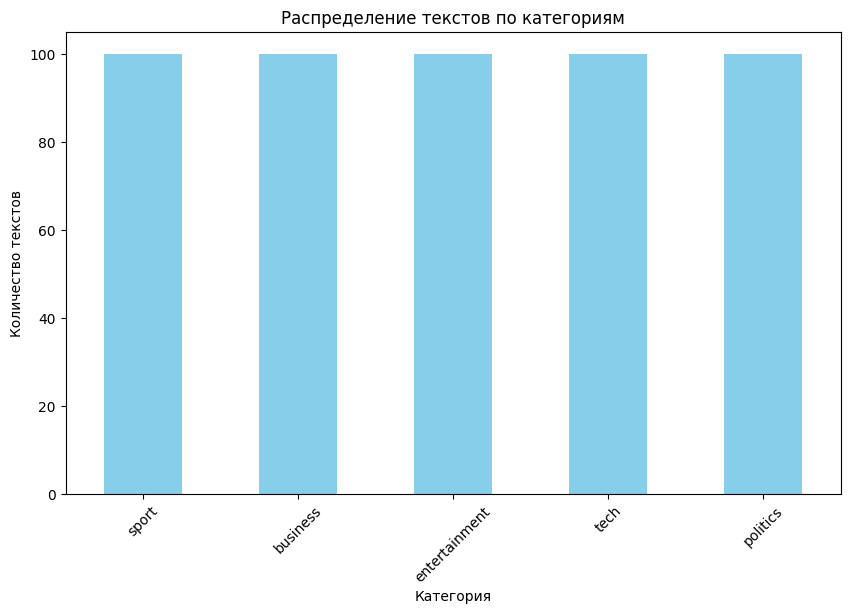

Обучающая выборка 400 текстов
Тестовая выборка 100 текстов
Accuracy: 0.950
Classification Report:
               precision    recall  f1-score   support

     business       0.95      0.90      0.92        20
entertainment       0.95      0.95      0.95        20
     politics       0.90      0.95      0.93        20
        sport       0.95      1.00      0.98        20
         tech       1.00      0.95      0.97        20

     accuracy                           0.95       100
    macro avg       0.95      0.95      0.95       100
 weighted avg       0.95      0.95      0.95       100



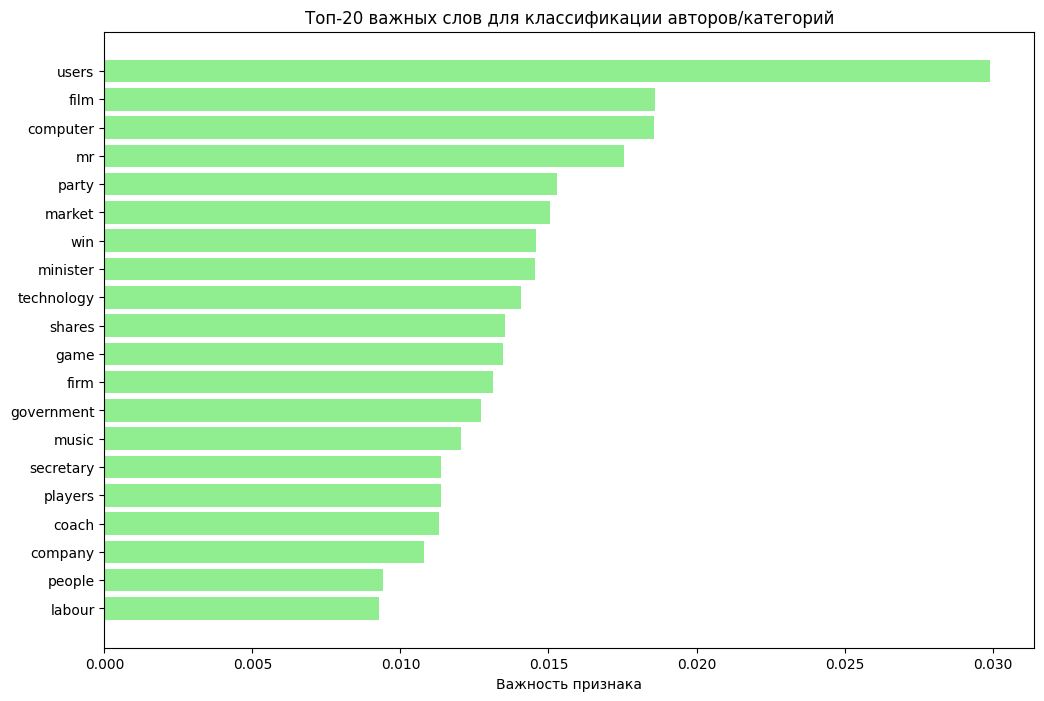

Предсказанная категория: business
Топ-3 вероятности:
     business: 0.548
     entertainment: 0.228
     sport: 0.083
Предсказанная категория: sport
Топ-3 вероятности:
     sport: 0.362
     entertainment: 0.297
     business: 0.198
Предсказанная категория: entertainment
Топ-3 вероятности:
     entertainment: 0.366
     business: 0.312
     politics: 0.134


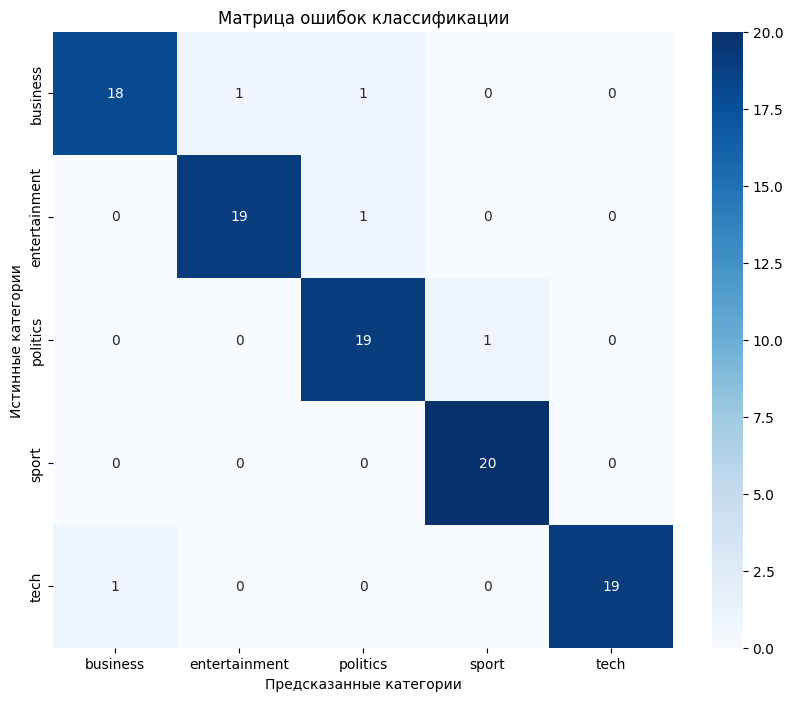

   Макс. признаков: 100, Accuracy: 0.900
   Макс. признаков: 250, Accuracy: 0.880
   Макс. признаков: 500, Accuracy: 0.950
   Макс. признаков: 1000, Accuracy: 0.940
   Макс. признаков: 2000, Accuracy: 0.900


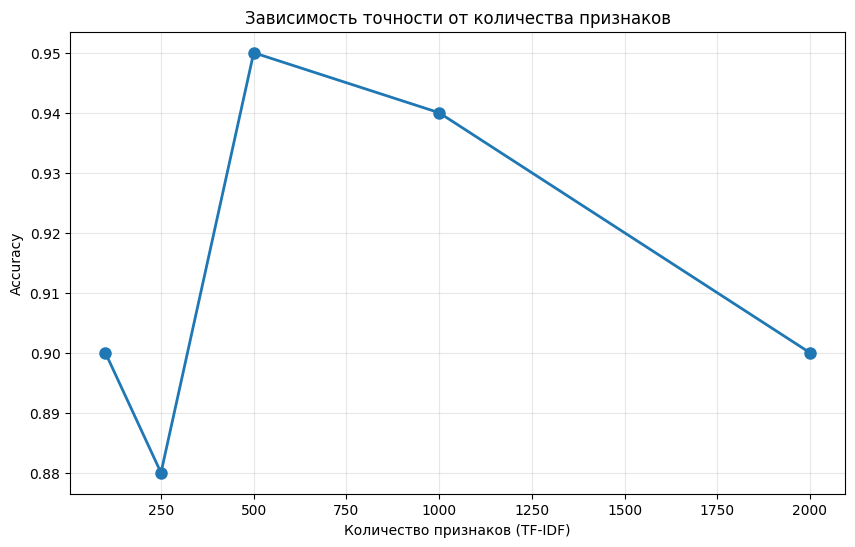

In [1]:
!pip install datasets

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset

print("Загрузка датасета BBC News")
dataset = load_dataset("SetFit/bbc-news")

df = pd.DataFrame(dataset['train'])

for i in range(3):
    print(f"Категория: {df.iloc[i]['label_text']}")
    print(f"Первые 100 символов: {df.iloc[i]['text'][:100]}...")

df_balanced = pd.DataFrame()
for category in df['label_text'].unique():
    category_samples = df[df['label_text'] == category].head(100)
    df_balanced = pd.concat([df_balanced, category_samples])


le = LabelEncoder()
df_balanced['label'] = le.fit_transform(df_balanced['label_text'])

plt.figure(figsize=(10, 6))
df_balanced['label_text'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Распределение текстов по категориям')
plt.xlabel('Категория')
plt.ylabel('Количество текстов')
plt.xticks(rotation=45)
plt.show()

vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    min_df=2,
    max_df=0.8
)

X = vectorizer.fit_transform(df_balanced['text'])
y = df_balanced['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Обучающая выборка {X_train.shape[0]} текстов")
print(f"Тестовая выборка {X_test.shape[0]} текстов")

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

feature_importances = model.feature_importances_
feature_names = vectorizer.get_feature_names_out()

indices = np.argsort(feature_importances)[-20:][::-1]

plt.figure(figsize=(12, 8))
plt.barh(range(20), feature_importances[indices], color='lightgreen')
plt.yticks(range(20), [feature_names[i] for i in indices])
plt.xlabel('Важность признака')
plt.title('Топ-20 важных слов для классификации авторов/категорий')
plt.gca().invert_yaxis()
plt.show()

test_texts = [
    "The stock market fell sharply today after the economic report was released.",
    "Manchester United won the championship after a dramatic final match.",
    "Scientists have discovered a new species of dinosaur in the desert."
]

for i, text in enumerate(test_texts):
    text_vec = vectorizer.transform([text])
    pred_label = model.predict(text_vec)[0]
    pred_category = le.inverse_transform([pred_label])[0]

    probabilities = model.predict_proba(text_vec)[0]
    top_3_idx = np.argsort(probabilities)[-3:][::-1]

    print(f"Предсказанная категория: {pred_category}")
    print(f"Топ-3 вероятности:")
    for idx in top_3_idx:
        category = le.inverse_transform([idx])[0]
        prob = probabilities[idx]
        print(f"     {category}: {prob:.3f}")


from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Матрица ошибок классификации')
plt.xlabel('Предсказанные категории')
plt.ylabel('Истинные категории')
plt.show()

max_features_list = [100, 250, 500, 1000, 2000]
accuracies = []

for max_features in max_features_list:
    vectorizer_simple = TfidfVectorizer(max_features=max_features, stop_words='english')
    X_simple = vectorizer_simple.fit_transform(df_balanced['text'])
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
        X_simple, y, test_size=0.2, random_state=42
    )

    model_simple = RandomForestClassifier(n_estimators=50, random_state=42)
    model_simple.fit(X_train_s, y_train_s)
    y_pred_s = model_simple.predict(X_test_s)
    acc = accuracy_score(y_test_s, y_pred_s)
    accuracies.append(acc)
    print(f"   Макс. признаков: {max_features}, Accuracy: {acc:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(max_features_list, accuracies, marker='o', linewidth=2, markersize=8)
plt.title('Зависимость точности от количества признаков')
plt.xlabel('Количество признаков (TF-IDF)')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)
plt.show()

# N-грамм модели

Цель задачи - научиться анализировать, какие слова чаще всего идут вместе в тексте.
Разбиваем текст на последовательности из N слов и смотрим статистику.
Был произведен частотный анализ биграмм, визуализированы самые частые сочетания и создан простой генератор текста.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


  1. 'moby dick'
  2. 'dick by'
  3. 'by herman'
  4. 'herman melville'
  5. 'melville etymology'
   1. 'of the' - 3 раз
   2. 'supplied by' - 2 раз
   3. 'his old' - 2 раз
   4. 'all the' - 2 раз
   5. 'the world' - 2 раз
   6. ''s dictionary' - 2 раз
   7. 'and of' - 2 раз
   8. 'poor devil' - 2 раз
   9. 'devil of' - 2 раз
  10. 'have gone' - 2 раз


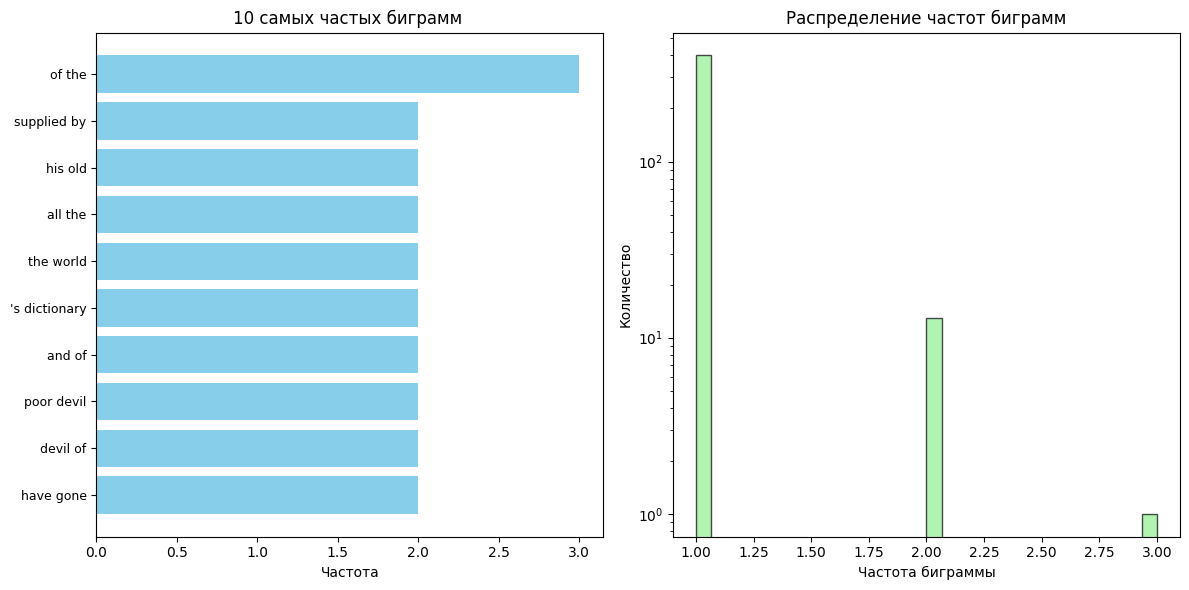

'the' → the signification of what has been
'and' → and for in coat heart body
'whale' → whale it is more pains ye
'moby' → moby dick by so much the
'grow' → grow convivial upon tears and dan


In [2]:
import nltk
from nltk.util import ngrams
from collections import Counter
import random
import re

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('gutenberg')

from nltk.corpus import gutenberg

selected_text = 'melville-moby_dick.txt'
text = gutenberg.raw(selected_text)[:3000]

def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)

    text = text.split('***')[2] if '***' in text else text

    text = re.sub(r'\b\d+\b', '', text)

    text = re.sub(r'\s+', ' ', text)

    text = re.sub(r'[^a-zA-Z\s.,!?;\-\'\"]', '', text)

    return text.strip()

text_clean = clean_text(text)

tokens = nltk.word_tokenize(text_clean.lower())

def filter_tokens(tokens):
    filtered = []
    for token in tokens:
        if re.match(r"^[a-z']+$", token) and len(token) > 1:
            filtered.append(token)
    return filtered

filtered_tokens = filter_tokens(tokens)
bigrams = list(ngrams(filtered_tokens, 2))
trigrams = list(ngrams(filtered_tokens, 3))

for i, bg in enumerate(bigrams[:5], 1):
    print(f"  {i}. '{bg[0]} {bg[1]}'")

bigram_freq = Counter(bigrams)

for i, (bg, count) in enumerate(bigram_freq.most_common(10), 1):
    print(f"  {i:2}. '{bg[0]} {bg[1]}' - {count} раз")

import matplotlib.pyplot as plt

top_bigrams = bigram_freq.most_common(10)
bg_words = [' '.join(bg[0]) for bg in top_bigrams]
bg_counts = [bg[1] for bg in top_bigrams]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.barh(range(len(bg_words)), bg_counts, color='skyblue')
plt.yticks(range(len(bg_words)), bg_words, fontsize=9)
plt.xlabel('Частота')
plt.title('10 самых частых биграмм ')
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
frequencies = list(bigram_freq.values())
plt.hist(frequencies, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
plt.xlabel('Частота биграммы')
plt.ylabel('Количество')
plt.title('Распределение частот биграмм')
plt.yscale('log')

plt.tight_layout()
plt.show()

def generate_from_words(start_word, max_length=8):
    result = [start_word]
    current = start_word

    for _ in range(max_length - 1):
        continuations = []
        for bg in bigrams:
            if bg[0] == current:
                continuations.append(bg[1])

        if continuations:
            next_word = random.choice(continuations)
            result.append(next_word)
            current = next_word
        else:
            break

    return ' '.join(result)

test_words = ['the', 'and', 'whale', 'moby', 'grow']
for word in test_words:
    if word in filtered_tokens:
        generated = generate_from_words(word, 6)
        print(f"'{word}' → {generated}")
    else:
        print(f"'{word}' → слова нет в тексте")

# Определение частей речи

Морфологический анализ русского текста. Для каждого слова определяем его начальную форму.
Был использован pymorphy3 для анализа русских предложений, статистики частей речи.

In [3]:
!pip install pymorphy3

import pymorphy3
import re

morph = pymorphy3.MorphAnalyzer()

text = "Красивая кошка быстро бежала по зелёной траве."
words = text.split()

for word in words:
    parsed = morph.parse(word)[0]


    pos = parsed.tag.POS
    normal_form = parsed.normal_form
    case = parsed.tag.case
    number = parsed.tag.number

    pos_names = {
        'NOUN': 'существительное',
        'ADJF': 'прилагательное',
        'VERB': 'глагол',
        'PRTF': 'причастие',
        'PRTS': 'причастие (краткое)',
        'GRND': 'деепричастие',
        'NUMR': 'числительное',
        'ADVB': 'наречие',
        'NPRO': 'местоимение',
        'PREP': 'предлог',
        'CONJ': 'союз',
        'PRCL': 'частица',
        'INTJ': 'междометие',
    }

    pos_russian = pos_names.get(pos, pos)


sample_text = """
Мама устроила генеральную уборку. Папа читал интересную газету.
Дети играли в весёлые игры. Собака громко лаяла.
Кот спал на тёплом подоконнике. Солнце ярко светило.
"""

def analyze_russian_text(text):

    words = re.findall(r'\b[а-яА-ЯёЁ]+\b', text.lower())

    results = []
    for word in words:
        parsed = morph.parse(word)[0]
        results.append({
            'word': word,
            'normal_form': parsed.normal_form,
            'pos': parsed.tag.POS,
            'gender': parsed.tag.gender,
            'number': parsed.tag.number,
            'case': parsed.tag.case,
            'tense': parsed.tag.tense if hasattr(parsed.tag, 'tense') else None
        })

    return results

analysis = analyze_russian_text(sample_text)

pos_counter = {}
for item in analysis:
    pos = item['pos']
    pos_counter[pos] = pos_counter.get(pos, 0) + 1

for pos, count in sorted(pos_counter.items(), key=lambda x: x[1], reverse=True):
    print(f"  {pos:10}: {count:3} слов")

def colorize_pos(text):
    tokens = re.findall(r'\b[а-яА-ЯёЁ]+\b|[.,!?;:]', text)

    for token in tokens:
        if re.match(r'^[а-яА-ЯёЁ]+$', token):
            parsed = morph.parse(token)[0]
            pos = parsed.tag.POS

            colors = {
                'NOUN': '\033[92m',    # зелёный - существительные
                'ADJF': '\033[94m',    # синий - прилагательные
                'VERB': '\033[91m',    # красный - глаголы
                'ADVB': '\033[93m',    # жёлтый - наречия
                'NPRO': '\033[95m',    # фиолетовый - местоимения
                'PREP': '\033[96m',    # голубой - предлоги
                'CONJ': '\033[97m',    # белый - союзы
                'PRCL': '\033[90m',    # серый - частицы
            }

            color = colors.get(pos, '\033[97m')
            pos_short = {
                'NOUN': 'СУЩ',
                'ADJF': 'ПРИЛ',
                'VERB': 'ГЛ',
                'ADVB': 'НАР',
                'NPRO': 'МЕСТ',
                'PREP': 'ПРЕДЛ',
                'CONJ': 'СОЮЗ',
                'PRCL': 'ЧАСТ',
            }.get(pos, pos)

            print(f"{color}{token}\033[0m({pos_short})", end=' ')
        else:
            print(f"\033[90m{token}\033[0m", end=' ')

    print()

colorize_pos(text)

def find_by_pos(text, target_pos):
    words = re.findall(r'\b[а-яА-ЯёЁ]+\b', text.lower())
    result = []

    for word in words:
        parsed = morph.parse(word)[0]
        if parsed.tag.POS == target_pos:
            result.append((word, parsed.normal_form))

    return result

nouns = find_by_pos(sample_text, 'NOUN')
print(f"Существительные ({len(nouns)}):")
for word, lemma in nouns:
    print(f"  {word} → {lemma}")

verbs = find_by_pos(sample_text, 'VERB')
print(f"Глаголы ({len(verbs)}):")
for word, lemma in verbs:
    print(f"  {word} → {lemma}")

adjectives = find_by_pos(sample_text, 'ADJF')
print(f"Прилагательные ({len(adjectives)}):")
for word, lemma in adjectives:
    print(f"  {word} → {lemma}")

def lemmatize_text(text):
    tokens = re.findall(r'\b[а-яА-ЯёЁ]+\b|[.,!?;:]', text)
    lemmatized = []

    for token in tokens:
        if re.match(r'^[а-яА-ЯёЁ]+$', token):
            parsed = morph.parse(token)[0]
            lemmatized.append(parsed.normal_form)
        else:
            lemmatized.append(token)

    return ' '.join(lemmatized)

lemmatized = lemmatize_text(sample_text)



def find_noun_phrases(text):
    tokens = re.findall(r'\b[а-яА-ЯёЁ]+\b|[.,!?;:]', text)
    phrases = []

    for i in range(len(tokens) - 1):
        if re.match(r'^[а-яА-ЯёЁ]+$', tokens[i]) and re.match(r'^[а-яА-ЯёЁ]+$', tokens[i+1]):
            word1_parsed = morph.parse(tokens[i])[0]
            word2_parsed = morph.parse(tokens[i+1])[0]

            if word1_parsed.tag.POS in ['ADJF', 'ADJS'] and word2_parsed.tag.POS == 'NOUN':
                phrases.append(f"{tokens[i]} {tokens[i+1]}")

    return phrases


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 54.1 MB/s eta 0:00:00
  NOUN      :  11 слов
  VERB      :   5 слов
  ADJF      :   4 слов
  PREP      :   2 слов
  ADVB      :   2 слов
Красивая(ПРИЛ) кошка(СУЩ) быстро(НАР) бежала(ГЛ) по(ПРЕДЛ) зелёной(ПРИЛ) траве(СУЩ) . 
Существительные (11):
  мама → мама
  уборку → уборка
  папа → папа
  газету → газета
  дети → ребёнок
  игры → игра
  собака → собака
  кот → кот
  подоконнике → подоконник
  солнце → солнце
  светило → светило
Глаголы (5):
  устроила → устроить
  читал → читать
  играли → играть
  лаяла → лаять
  спал → спасть
Прилагательные (4):
  генеральную → генеральный
  интересную → интересный
  весёлые → весёлый
  тёплом → тёплый


# Грамматический разбор текста

Определяем грамматические связи между словами: кто что делает, к кому относится, какими словами описывается.
С помощью spaCy построены деревья зависимостей, выделены главные члены предложения, созданы грамматические схемы.

In [4]:
!pip install spacy
!python -m spacy download ru_core_news_sm

import spacy
from spacy import displacy

nlp = spacy.load("ru_core_news_sm")

text = "Кот ловит мышь в саду."
doc = nlp(text)

for token in doc:
    print(f"{token.text:10} -> POS: {token.pos_:8} | Tag: {token.tag_:10} | Dep: {token.dep_:10} | Lemma: {token.lemma_}")

pos_explanations = {
    'NOUN': 'существительное',
    'PROPN': 'имя собственное',
    'VERB': 'глагол',
    'ADJ': 'прилагательное',
    'ADV': 'наречие',
    'PRON': 'местоимение',
    'DET': 'артикль/детерминатив',
    'ADP': 'предлог',
    'CCONJ': 'сочинительный союз',
    'SCONJ': 'подчинительный союз',
    'PART': 'частица',
    'INTJ': 'междометие',
    'NUM': 'числительное',
    'PUNCT': 'знак препинания'
}

tag_explanations = {
    'Animacy=Anim': 'одушевлённое',
    'Animacy=Inan': 'неодушевлённое',
    'Aspect=Imp': 'несовершенный вид',
    'Aspect=Perf': 'совершенный вид',
    'Case=Nom': 'именительный падеж',
    'Case=Gen': 'родительный падеж',
    'Case=Dat': 'дательный падеж',
    'Case=Acc': 'винительный падеж',
    'Case=Ins': 'творительный падеж',
    'Case=Loc': 'предложный падеж',
    'Gender=Masc': 'мужской род',
    'Gender=Fem': 'женский род',
    'Gender=Neut': 'средний род',
    'Mood=Ind': 'изъявительное наклонение',
    'Number=Sing': 'единственное число',
    'Number=Plur': 'множественное число',
    'Person=1': '1 лицо',
    'Person=2': '2 лицо',
    'Person=3': '3 лицо',
    'Tense=Past': 'прошедшее время',
    'Tense=Pres': 'настоящее время',
    'Tense=Fut': 'будущее время',
    'VerbForm=Inf': 'инфинитив',
    'Voice=Act': 'действительный залог',
    'Voice=Pass': 'страдательный залог',
}

for token in doc:
    pos_ru = pos_explanations.get(token.pos_, token.pos_)

    tag_parts = []
    if token.tag_:
        for part in token.tag_.split('|'):
            if part in tag_explanations:
                tag_parts.append(tag_explanations[part])
            else:
                tag_parts.append(part)

    tag_description = ', '.join(tag_parts) if tag_parts else token.tag_

    print(f"{token.text:10} -> {pos_ru:20} | {tag_description}")

words_by_pos = {}
for token in doc:
    if token.pos_ not in words_by_pos:
        words_by_pos[token.pos_] = []
    words_by_pos[token.pos_].append(token.text)

for pos, words in words_by_pos.items():
    pos_ru = pos_explanations.get(pos, pos)
    print(f"{pos_ru:20}: {', '.join(words)}")

dep_explanations = {
    'ROOT': 'корень предложения',
    'nsubj': 'подлежащее',
    'obj': 'прямое дополнение',
    'iobj': 'косвенное дополнение',
    'obl': 'обстоятельство',
    'advmod': 'обстоятельственное наречие',
    'amod': 'определение',
    'nummod': 'числительное',
    'case': 'предлог/падеж',
    'conj': 'союзное слово',
    'cc': 'сочинительный союз',
    'punct': 'знак препинания',
    'xcomp': 'дополнение',
}

for token in doc:
    dep_ru = dep_explanations.get(token.dep_, token.dep_)
    head_text = token.head.text if token.head != token else "(корень)"
    print(f"{token.text:10} -> {dep_ru:25} -> {head_text:10}")


subj = [token for token in doc if token.dep_ in ["nsubj", "nsubj:pass"]]
pred = [token for token in doc if token.dep_ == "ROOT"]
obj = [token for token in doc if token.dep_ in ["obj", "iobj"]]
obl = [token for token in doc if token.dep_ == "obl"]
amod = [token for token in doc if token.dep_ == "amod"]
advmod = [token for token in doc if token.dep_ == "advmod"]

print(f"Подлежащее:     {[s.text for s in subj]}")
print(f"Сказуемое:      {[p.text for p in pred]}")
print(f"Дополнение:     {[o.text for o in obj]}")
print(f"Обстоятельство: {[o.text for o in obl]}")
print(f"Определение:    {[a.text for a in amod]}")
print(f"Наречие:        {[a.text for a in advmod]}")



displacy.render(doc, style="dep", jupyter=True, options={'distance': 100})

bigger_text = """
Быстрая рыжая лиса прыгает с грацией.
Вчера мы ходили в большой магазин и купили свежих яблок.
Мой брат, который живёт в Москве, приедет завтра.
"""

print(f"Текст:\n{bigger_text}\n")

doc2 = nlp(bigger_text)

pos_stats = {}
for token in doc2:
    if token.pos_ not in pos_stats:
        pos_stats[token.pos_] = 0
    pos_stats[token.pos_] += 1

for pos, count in sorted(pos_stats.items(), key=lambda x: x[1], reverse=True):
    pos_ru = pos_explanations.get(pos, pos)
    print(f"  {pos_ru:25}: {count:3}")


def create_sentence_scheme(doc):
    scheme = []

    for sent in doc.sents:
        sent_scheme = []
        for token in sent:
            if token.pos_ == 'PUNCT':
                continue

            if token.dep_ in ['nsubj', 'nsubj:pass']:
                sent_scheme.append(f"[подл: {token.text}]")
            elif token.dep_ == 'ROOT':
                sent_scheme.append(f"[сказ: {token.text}]")
            elif token.dep_ in ['obj', 'iobj']:
                sent_scheme.append(f"[доп: {token.text}]")
            elif token.dep_ == 'obl':
                sent_scheme.append(f"[обст: {token.text}]")
            elif token.dep_ == 'amod':
                sent_scheme.append(f"[опр: {token.text}]")
            else:
                sent_scheme.append(f"[{token.pos_}: {token.text}]")

        scheme.append(' '.join(sent_scheme))

    return scheme

first_sentence = list(doc2.sents)[0]
scheme = create_sentence_scheme(nlp(str(first_sentence)))
print(f"Предложение: {first_sentence}")
print(f"Схема: {scheme[0]}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 72.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Кот        -> POS: NOUN     | Tag: NOUN       | Dep: nsubj      | Lemma: кот
ловит      -> POS: VERB     | Tag: VERB       | Dep: ROOT       | Lemma: ловить
мышь       -> POS: NOUN     | Tag: NOUN       | Dep: obj        | Lemma: мышь
в          -> POS: ADP      | Tag: ADP        | Dep: case       | Lemma: в
саду       -> POS: NOUN     | Tag: NOUN       | Dep: obl        | Lemma: сад
.          -> POS: PUNCT    | Tag: PUNCT      | Dep: punct      | Lemma: .
Кот        -> существительное      | NOUN
ловит      -> глагол               | VERB
мышь       -> существительное      |

Текст:

Быстрая рыжая лиса прыгает с грацией.
Вчера мы ходили в большой магазин и купили свежих яблок.
Мой брат, который живёт в Москве, приедет завтра.


  прилагательное           :   5
  существительное          :   5
  знак препинания          :   5
  SPACE                    :   4
  глагол                   :   4
  предлог                  :   3
  наречие                  :   2
  местоимение              :   2
  сочинительный союз       :   1
  артикль/детерминатив     :   1
  имя собственное          :   1
Предложение: 
Быстрая рыжая лиса прыгает с грацией.

Схема: [SPACE: 
] [опр: Быстрая] [опр: рыжая] [подл: лиса] [сказ: прыгает] [ADP: с] [обст: грацией] [SPACE: 
]


# Пример коллокаций по статистике

[nltk_data] Downloading package webtext to /root/nltk_data...
[nltk_data]   Unzipping corpora/webtext.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Топ-10 коллокаций по PMI:
[('bin', 'laden'), ('united', 'states'), ('meth', 'addict'), ('taco', 'bell'), ('tony', 'danza'), ('shrewd', 'observer'), ('paris', 'hilton'), ('puerto', 'rican'), ('matzoh', 'ball'), ('deaf', 'malay')]
Топ-10 коллокаций по t-score:
[('#', '1'), ('1', ':'), ('#', '2'), ('2', ':'), ('guy', ':'), ('girl', '#'), ('i', "'m"), ('do', "n't"), ('girl', ':'), (':', 'i')]


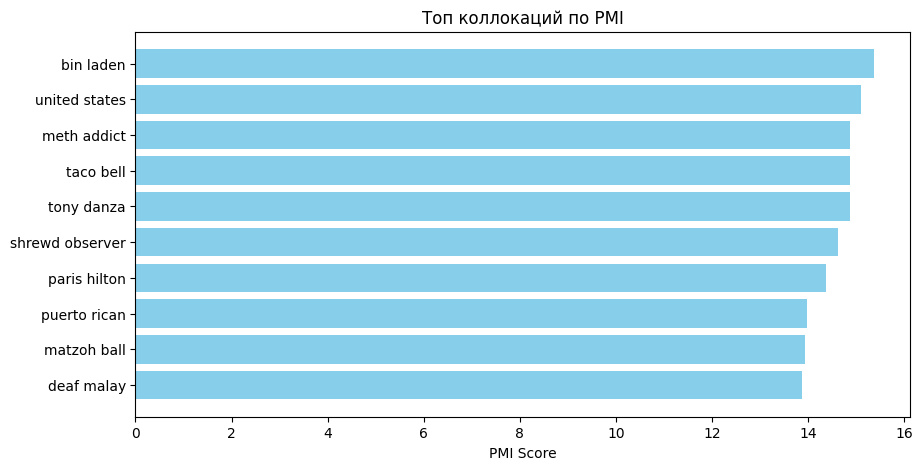

In [5]:
!pip install nltk

import nltk
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.corpus import webtext
import matplotlib.pyplot as plt

nltk.download('webtext')
nltk.download('punkt')

text = webtext.raw('overheard.txt')
tokens = nltk.word_tokenize(text.lower())

bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(tokens)

finder.apply_freq_filter(5)

print("Топ-10 коллокаций по PMI:")
print(finder.nbest(bigram_measures.pmi, 10))

print("Топ-10 коллокаций по t-score:")
print(finder.nbest(bigram_measures.student_t, 10))

top_bigrams = finder.nbest(bigram_measures.pmi, 10)
words, scores = zip(*[(f"{a} {b}", finder.score_ngram(bigram_measures.pmi, a, b)) for a, b in top_bigrams])

plt.figure(figsize=(10, 5))
plt.barh(words, scores, color='skyblue')
plt.xlabel('PMI Score')
plt.title('Топ коллокаций по PMI')
plt.gca().invert_yaxis()
plt.show()

# Поиск коллокаций

Обучаем нейросеть представлять слова как векторы в многомерном пространстве.Близкие векторы = близкие по смыслу слова. Обучил Word2Vec на датасете новостей, который находит семантически близкие слова. Визуализированы векторы через t-SNE, а слова сгруппированы по кластерам.

Обработано 0/100 текстов
Обработано 20/100 текстов
Обработано 40/100 текстов
Обработано 60/100 текстов
Обработано 80/100 текстов
Подготовлено 100 токенизированных текстов
Всего уникальных слов: 17128
  Начинается эпоха 1
  Начинается эпоха 2
  Начинается эпоха 3
  Начинается эпоха 4
  Начинается эпоха 5
  Завершена эпоха 5
  Начинается эпоха 6
  Начинается эпоха 7
  Начинается эпоха 8
  Начинается эпоха 9
  Начинается эпоха 10
  Завершена эпоха 10
  Начинается эпоха 11
  Начинается эпоха 12
  Начинается эпоха 13
  Начинается эпоха 14
  Начинается эпоха 15
  Завершена эпоха 15
  Начинается эпоха 16
  Начинается эпоха 17
  Начинается эпоха 18
  Начинается эпоха 19
  Начинается эпоха 20
  Завершена эпоха 20
Первые 20 слов в словаре: ['что', 'как', 'это', 'для', 'его', 'будет', 'все', 'при', 'уже', 'только', 'года', 'россии', 'также', 'если', 'году', 'они', 'так', 'еще', 'этом', 'было']
Тестируем слова: ['компания', 'рынок', 'правительство', 'россия']
Слова, похожие на 'компания':
  китая:

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


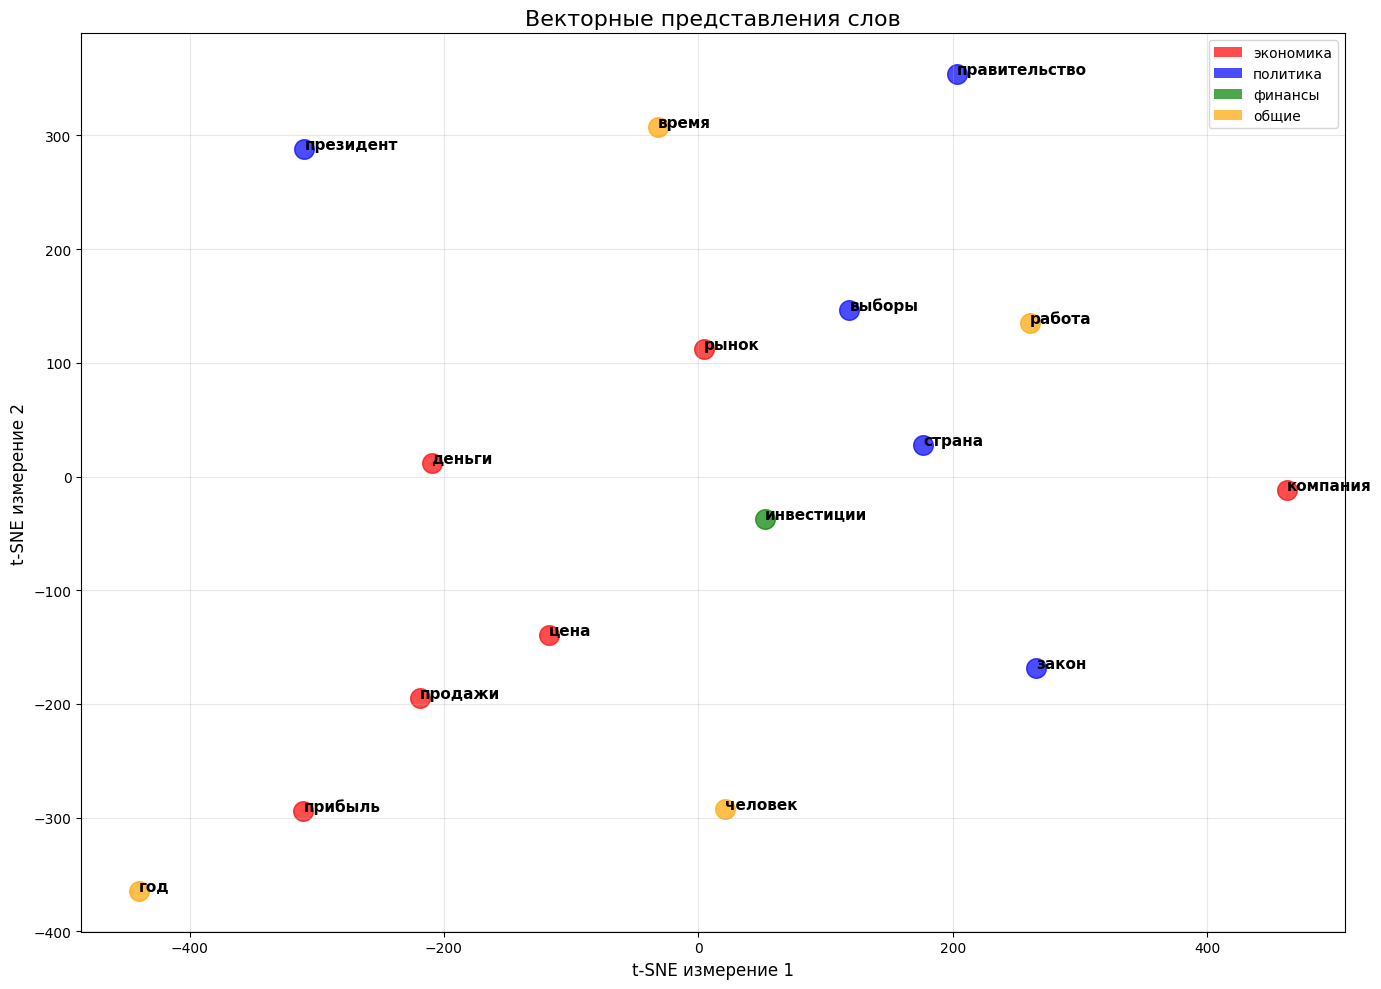

Найдено 5 кластеров:
Кластер 1 (13 слов):
  при, россии, этом, будут, компании, считает, мнению, говорит, сергей, всех
  Центроид похож на: ['законопроекта', 'учитываться', 'утилизационной']
Кластер 2 (11 слов):
  году, еще, сейчас, всего, лет, млрд, рублей, тысяч, год, человек
  Центроид похож на: ['стоимостью', 'владелец', 'стоят']
Кластер 3 (2 слов):
  того, кроме
Кластер 4 (40 слов):
  что, как, это, будет, уже, только, если, они, или, может
  Центроид похож на: ['тебя', 'осталось', 'отношение']
Кластер 5 (34 слов):
  для, его, все, года, также, так, было, том, после, который
  Центроид похож на: ['написал', 'бежать', 'жители']
Семантическое поле слова 'компания':
  китая (сходство: 0.880)
  весной (сходство: 0.858)
  реакция (сходство: 0.850)
  прекратила (сходство: 0.838)
  офис (сходство: 0.835)
  свой (сходство: 0.822)
  решила (сходство: 0.821)
  зато (сходство: 0.818)
  властей (сходство: 0.813)
  китайских (сходство: 0.795)
Контекстные соседи 'компания':
Найдено 6 контекстов

In [9]:
!pip install gensim scikit-learn matplotlib
!pip install datasets

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from datasets import load_dataset

dataset = load_dataset("IlyaGusev/gazeta", split='train[:5000]')

texts = [item['text'] for item in dataset]


import re
from nltk.tokenize import word_tokenize
import nltk


def preprocess_text(text):
    text = text.lower()

    text = re.sub(r'[^а-яёa-z\s]', ' ', text)

    text = re.sub(r'\s+', ' ', text).strip()

    return text

tokenized_texts = []
for i, text in enumerate(texts[:100]):
    if i % 20 == 0:
        print(f"Обработано {i}/{len(texts[:100])} текстов")

    cleaned = preprocess_text(text)
    tokens = word_tokenize(cleaned)

    tokens = [token for token in tokens if len(token) > 2]

    if tokens:
        tokenized_texts.append(tokens)

print(f"Подготовлено {len(tokenized_texts)} токенизированных текстов")
print(f"Всего уникальных слов: {len(set([word for text in tokenized_texts for word in text]))}")


from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec


class EpochLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0

    def on_epoch_begin(self, model):
        print(f"  Начинается эпоха {self.epoch + 1}")

    def on_epoch_end(self, model):
        self.epoch += 1
        if self.epoch % 5 == 0:
            print(f"  Завершена эпоха {self.epoch}")

model = Word2Vec(
    sentences=tokenized_texts,
    vector_size=100,
    window=5,
    min_count=3,
    workers=4,
    epochs=20,
    callbacks=[EpochLogger()],
    sg=1
)


vocab_words = list(model.wv.index_to_key)[:20]
print(f"Первые 20 слов в словаре: {vocab_words}")

test_words = []
for word in ['компания', 'рынок', 'доллар', 'правительство', 'россия']:
    if word in model.wv:
        test_words.append(word)

if not test_words:
    test_words = []
    for word in ['company', 'market', 'dollar', 'government', 'price']:
        if word in model.wv:
            test_words.append(word)

print(f"Тестируем слова: {test_words}")

for word in test_words[:3]:
    if word in model.wv:
        similar = model.wv.most_similar(word, topn=5)
        print(f"Слова, похожие на '{word}':")
        for w, score in similar:
            print(f"  {w}: {score:.3f}")


def calculate_similarity(word1, word2):
    if word1 in model.wv and word2 in model.wv:
        vec1 = model.wv[word1]
        vec2 = model.wv[word2]
        dot_product = np.dot(vec1, vec2)
        norm1 = np.linalg.norm(vec1)
        norm2 = np.linalg.norm(vec2)
        if norm1 > 0 and norm2 > 0:
            return dot_product / (norm1 * norm2)
    return None

if len(test_words) >= 2:
    word_pairs = [(test_words[i], test_words[i+1]) for i in range(len(test_words)-1)]

    for word1, word2 in word_pairs:
        similarity = calculate_similarity(word1, word2)
        if similarity is not None:
            print(f"  '{word1}' - '{word2}': {similarity:.3f}")
        else:
            print(f"  Одно из слов '{word1}' или '{word2}' отсутствует в модели")


try:
    words_to_visualize = []

    thematic_groups = {
        'экономика': ['компания', 'рынок', 'деньги', 'цена', 'продажи', 'прибыль'],
        'политика': ['правительство', 'президент', 'закон', 'выборы', 'страна'],
        'финансы': ['доллар', 'рубль', 'банк', 'кредит', 'инвестиции'],
        'общие': ['год', 'время', 'человек', 'работа', 'город']
    }

    for group, words in thematic_groups.items():
        for word in words:
            if word in model.wv and word not in words_to_visualize:
                words_to_visualize.append((word, group))

    if len(words_to_visualize) < 10:
        english_words = ['company', 'market', 'price', 'government', 'president',
                        'law', 'money', 'bank', 'year', 'time', 'people', 'work']
        for word in english_words:
            if word in model.wv:
                words_to_visualize.append((word, 'english'))

    print(f"Выбрано {len(words_to_visualize)} слов для визуализации")

    if len(words_to_visualize) >= 8:
        words = [item[0] for item in words_to_visualize]
        groups = [item[1] for item in words_to_visualize]

        vectors = np.array([model.wv[word] for word in words])

        tsne = TSNE(
            n_components=2,
            random_state=42,
            perplexity=min(5, len(words)-1),
            learning_rate=200,
            n_iter=1000
        )

        vectors_2d = tsne.fit_transform(vectors)

        plt.figure(figsize=(14, 10))

        group_colors = {
            'экономика': 'red',
            'политика': 'blue',
            'финансы': 'green',
            'общие': 'orange',
            'english': 'purple'
        }

        for i, (word, group) in enumerate(words_to_visualize):
            color = group_colors.get(group, 'gray')
            plt.scatter(vectors_2d[i, 0], vectors_2d[i, 1],
                       c=color, s=200, alpha=0.7, label=group if i == 0 else "")
            plt.text(vectors_2d[i, 0]+0.02, vectors_2d[i, 1]+0.02,
                    word, fontsize=11, fontweight='bold')

        plt.title('Векторные представления слов', fontsize=16)
        plt.xlabel('t-SNE измерение 1', fontsize=12)
        plt.ylabel('t-SNE измерение 2', fontsize=12)
        plt.grid(True, alpha=0.3)

        from matplotlib.patches import Patch
        legend_elements = []
        for group, color in group_colors.items():
            if any(g == group for _, g in words_to_visualize):
                legend_elements.append(Patch(facecolor=color, alpha=0.7, label=group))

        if legend_elements:
            plt.legend(handles=legend_elements, loc='upper right')

        plt.tight_layout()
        plt.show()
    else:
      pass

except Exception as e:
    print(f"Ошибка при визуализации: {e}")
    import traceback
    traceback.print_exc()


try:
    top_words = list(model.wv.index_to_key)[:100]

    if len(top_words) >= 20:
        vectors = np.array([model.wv[word] for word in top_words])

        n_clusters = min(5, len(top_words) // 10)
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(vectors)

        cluster_words = {i: [] for i in range(n_clusters)}
        for word, cluster in zip(top_words, clusters):
            cluster_words[cluster].append(word)

        print(f"Найдено {n_clusters} кластеров:")
        for cluster_id, words in cluster_words.items():
            print(f"Кластер {cluster_id + 1} ({len(words)} слов):")
            print("  " + ", ".join(words[:10]) + ("" if len(words) > 10 else ""))

            if len(words) >= 3:
                centroid = kmeans.cluster_centers_[cluster_id]
                similar_to_centroid = model.wv.similar_by_vector(centroid, topn=3)
                print(f"  Центроид похож на: {[w for w, _ in similar_to_centroid]}")

    else:
        print("Недостаточно слов для кластеризации")

except Exception as e:
    print(f"Ошибка при кластеризации: {e}")


def find_semantic_field(word, topn=10):
    if word in model.wv:
        similar_words = model.wv.most_similar(word, topn=topn)

        print(f"Семантическое поле слова '{word}':")
        for w, score in similar_words:
            print(f"  {w} (сходство: {score:.3f})")

        print(f"Контекстные соседи '{word}':")

        contexts = []
        for tokens in tokenized_texts[:50]:
            if word in tokens:
                idx = tokens.index(word)
                start = max(0, idx - 2)
                end = min(len(tokens), idx + 3)
                context = tokens[start:end]
                contexts.append(context)

        if contexts:
            print(f"Найдено {len(contexts)} контекстов")
            print("Примеры:")
            for i, context in enumerate(contexts[:3]):
                context_str = " ".join(context)
                print(f"    {i+1}. {context_str}")
        else:
            print(f"Контексты не найдены")
    else:
        print(f"Слово '{word}' отсутствует в модели")

test_semantic_words = []
for word in ['компания', 'рынок', 'деньги', 'работа']:
    if word in model.wv:
        test_semantic_words.append(word)

if not test_semantic_words:
    for word in ['company', 'market', 'money', 'work']:
        if word in model.wv:
            test_semantic_words.append(word)

for word in test_semantic_words[:2]:
    find_semantic_field(word)
    print()

model.save("word2vec_real_data.model")
print("Модель сохранена как 'word2vec_real_data.model'")

# loaded_model = Word2Vec.load("word2vec_real_data.model")